<a href="https://colab.research.google.com/github/FrankJRix/lab_util/blob/main/lab_utility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,vin(V),vout,vidiv,vodiv,dt(s),freq(Hz),err_vin,err_vout,T,err_T
0,0.763,0.6380,0.5,1,NaN,10,0.14,0.28,-1.554077,4.131740
1,0.744,1.1760,0.5,1,NaN,20,0.14,0.28,3.976688,2.635964
2,0.769,2.5750,0.5,1,NaN,50,0.14,0.28,10.497018,1.841896
3,0.792,3.3500,0.5,1,NaN,70,0.14,0.28,12.526393,1.698370
4,0.738,3.7250,0.5,1,NaN,85,0.14,0.28,14.061398,1.772369
5,0.775,3.9875,0.5,1,NaN,95,0.14,0.28,14.227980,1.683438
6,0.750,4.1125,0.5,1,NaN,100,0.14,0.28,14.780893,1.725850
7,0.738,4.1625,0.5,1,NaN,105,0.14,0.28,15.025958,1.748254
8,0.775,4.1875,0.5,1,NaN,110,0.14,0.28,14.653062,1.673104
9,0.744,5.1125,0.5,1,NaN,200,0.14,0.28,16.741208,1.702262


128.79294147242476 1.5779923868575148
156209.48775452943 0.0


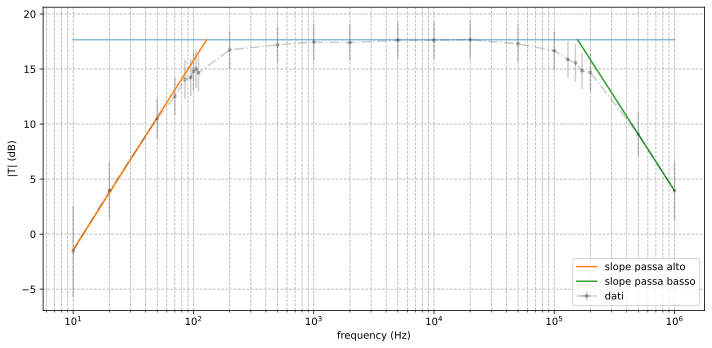

In [1]:
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import linregress as linfit

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg') # se su colab, in locale commentata

# la parte sotto va commentata su colab e scommentata in locale su una macchina aggiornata
#import matplotlib_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

fil = 'tr_corretto.csv'

# def funzioni

def errori_osc_volt(valori, div):
    """ si aspetta un array di valori misurati e uno di volt/div come da oscilloscopio
    in output array di errori """
    errors = []

    if len(valori) != len(div):
        print('mismatched input size')
        return
    
    for j in range(len(valori)):
        if div[j] >= 10e-3:
            percent = 0.03
        else:
            percent = 0.04

        scala = div[j]*8
        err = percent*scala + 0.005*scala

        errors.append(err)

        #print(f'{j+1}: ({valori[j]:.3g} +/- {err:.3g})V (scala: {scala}V)')
    
    errors = np.array(errors)
    #print('\n')

    return errors

def errori_osc_tempo(valori, div):
    """ si aspetta un array di valori misurati e uno di s/div come da oscilloscopio """
    errors = []

    if len(valori) != len(div):
        print('mismatched input size')
        return
    
    acc = 50e-6
    off = 200e-12
    factor = 16e-3 #16e-4 * num divisioni orizzontali

    for j in range(len(valori)):
        err = acc*valori[j] + off + factor*div[j]
        
        #print(f'{j+1}: ({valori[j]:.3g} +/- {err:.3g})s')
        errors.append(err)
    
    errors = np.array(errors)
    #print('\n')

    return errors

def leggi_csv(path):
    """ path relativo fino al .csv """
    data = pd.read_csv(path)
    data = data.replace(',','.', regex=True)
    data = data.apply(pd.to_numeric, errors='coerce')
    return data

def compute_phi(dt, err_t, f, err_f = []):
    """ si aspetta quattro (tre) array di valori di dt, errore su dt, frequenza e errore su frequenza (facoltativo)
    in output due array phi e err_phi """
    if len(dt) != len(f):
        print('mismatched input size')
        return
    if len(err_f) == 0:
        err_f = np.zeros(len(f))
    dt = np.array(dt)
    f = np.array(f)
    err_t = np.array(err_t)
    err_f = np.array(err_f)

    conv = 360/(2*np.pi)

    phi = 2*np.pi * f * dt
    phi = conv * phi

    err_phi = conv * np.sqrt((2*np.pi*f*err_t)**2+(2*np.pi*dt*err_f)**2)
    return phi, err_phi

def error_format(val, err):
    """ si aspetta un array di valori e uno di errori 
    in output array di stringhe formattate in latex pronte per tabella"""
    if len(val) != len(err):
        print('mismatched input size')
        return
    out = []
    for i in range(len(val)):
        tmp = f'{val[i]:.3g} $\pm$ {err[i]:.3g}'
        out.append(tmp)
    
    return out

def transf_func(vin, vout, err_vin = [], err_vout = []):
    """ quattro (due) array, V_in, V_out e rispettivi errori (facoltativi)
    output modulo e errore di T """
    vin = np.array(vin)
    vout = np.array(vout)
    if len(err_vin) == 0:
        err_vin = np.zeros(len(vin))
    else:
        err_vin = np.array(err_vin)
    if len(err_vin) == 0:
        err_vout = np.zeros(len(vout))
    else:
        err_vout = np.array(err_vout)

    x = 20 * np.log10(vout/vin)
    err_x = 20*np.sqrt( (err_vout/vout)**2 + (err_vin/vin)**2) / np.log(10)

    return x, err_x

def bode_plot(T, f, err_T, err_f = [],  phi = [], err_phi = [], n_pa = 0, n_pb = 0):
    """ sei (cinque) array, modulo di T, fase di T, frequenza e rispettivi errori (facoltativo quello su f)
    num di valori per calcolare freq di taglio per pa e pb (facoltativi, servono per fit)
    output grafici e stima di freq taglio """
    if len(err_f) == 0:
        err_f = np.zeros(len(f))
    if len(err_phi) == 0:
        err_phi = np.zeros(len(f))

    t = np.linspace(f.min(), f.max(), 2)

    plt.figure(figsize=(10,5))
    plt.errorbar(f, T, yerr=err_T, xerr=err_f, label='dati', marker='.', linestyle='-.', alpha = 0.2, color='black')
    plt.plot(t, np.ones(len(t))*T.max(), alpha=0.5)

    if n_pa:
        l = np.log(f[:n_pa])

        fit_pa = linfit(l, T[:n_pa])

        q = fit_pa.intercept
        dq = fit_pa.intercept_stderr
        m = fit_pa.slope
        dm = fit_pa.stderr

        ft_pa = np.exp((T.max()-q)/m)
        err_ft_pa = np.sqrt( ((m*dq)**2+(q*dm)**2)*np.exp(-2*q/m) / m**4)
        print(ft_pa, err_ft_pa)

        t_pa = np.linspace(f.min(), ft_pa, 2)
        l_pa = np.log(t_pa)

        plt.plot(t_pa, m*l_pa + q, label='slope passa alto')

    if n_pb:
        l = np.log(f[-n_pb:])

        fit_pb = linfit(l, T[-n_pb:])

        q = fit_pb.intercept
        dq = fit_pb.intercept_stderr
        m = fit_pb.slope
        dm = fit_pb.stderr

        ft_pb = np.exp((T.max()-q)/m)
        err_ft_pb = np.sqrt( ((m*dq)**2+(q*dm)**2)*np.exp(-2*q/m) / m**4)
        print(ft_pb, err_ft_pb)

        t_pb = np.linspace(f.max(), ft_pb, 2)
        l_pb = np.log(t_pb)

        plt.plot(t_pb, m*l_pb + q, label='slope passa basso')

    plt.semilogx()
    plt.xlabel('frequency (Hz)')
    plt.ylabel('|T| (dB)')
    plt.grid(True, 'both', linestyle='--')

    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig("bode_T.svg", bbox_inches='tight')
    plt.show()

    if len(phi) > 0:
        plt.figure(figsize=(10,5))
        plt.errorbar(f, phi, yerr=err_phi, xerr=err_f, label='dati', marker='.', linestyle='-.', alpha = 0.2, color='black')
        plt.semilogx()
        plt.xlabel('frequency (Hz)')
        plt.ylabel('$d\phi$ (deg)')
        plt.grid(True, 'both', linestyle='--')

        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.savefig("bode_phi.svg", bbox_inches='tight')
        plt.show()

def analisi_risposta(path, n_pa = 0, n_pb = 0, has_dt = False):
    """ path: path al .csv
    n_pa: num misure per fit passa alto
    n_pb: num misure per fit passa basso
    has_dt: True se c'è l'analisi di phi, default False """
    data = leggi_csv(path)
    #display(data)
    err_vi = errori_osc_volt(data['vin(V)'], data['vidiv'])
    err_vo = errori_osc_volt(data['vout'], data['vodiv'])

    data.insert(len(data.columns), 'err_vin', err_vi)
    data.insert(len(data.columns), 'err_vout', err_vo)

    T, err_T = transf_func(data['vin(V)'], data['vout'], data['err_vin'], data['err_vout'])
    data.insert(len(data.columns), 'T', T)
    data.insert(len(data.columns), 'err_T', err_T)
    
    if has_dt:
        err_t = errori_osc_tempo(data['dt(s)'], data['tdiv'])
        data.insert(len(data.columns), 'err_t', err_t)
        phi , err_phi = compute_phi(data['dt(s)'], data['err_t'], data['freq(Hz'])
        data.insert(len(data.columns), 'phi', phi)
        data.insert(len(data.columns), 'err_phi', err_phi)
    
    display(data)
    bode_plot(data['T'], data['freq(Hz)'], data['err_T'], n_pa=n_pa, n_pb=n_pb)

#playground

#esempio finale
analisi_risposta(fil, 3, 2)

#valori divisioni
#d_in = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
#d_out = [10e-3, 50e-3, 100e-3, 500e-3, 500e-3, 500e-3, 500e-3, 1, 1, 1, 1, 1, 1]
#d_t = [5e-3, 10e-4, 5e-4, 5e-5, 5e-5, 5e-5, 5e-5, 5e-5, 1e-6, 1e-6, 2e-7, 2e-7, 2e-8]

#esempio leggi_csv
#data = leggi_csv(fil)

#fix per errore scala
#data['vout'] = data['vout'] * 2
#data.to_csv('tr_corretto.csv')

#display(data)
#aggiustamenti al dataframe per dopo
#data.insert(0, 'div_vin', d_in)
#data.insert(0, 'div_vout', d_out)
#data.insert(0, 'div_t', d_t)
#data = data.drop(columns=['T', 'dt', 'dV'])

#esempio uso errori_osc_[]
#err_vi = errori_osc_volt(data['vin(V)'], data['vidiv'])
#err_vo = errori_osc_volt(data['vout'], data['vodiv'])
#err_t = errori_osc_tempo(data['t'], data['div_t'])

#data.insert(0, 'err_vin', err_vi)
#data.insert(0, 'err_vout', err_vo)
#data.insert(0, 'err_t', err_t)

#esempio uso compute_phi
#phi , err_phi = compute_phi(data['t'], data['err_t'], data['f'])

#data.insert(0, 'phi', phi)
#data.insert(0, 'err_phi', err_phi)

#esempio uso error_format
#a =  error_format(data['phi'], data['err_phi'])
#b =  error_format(data['V_i'], data['err_vin'])
#c =  error_format(data['V_o'], data['err_vout'])

#tab = pd.DataFrame()
#tab.insert(0, 'phi', a)
#tab.insert(0, 'vin', b)
#tab.insert(0, 'vout', c)

#esempio uso transf_func
#T, err_T = transf_func(data['vin(V)'], data['vout'], data['err_vin'], data['err_vout'])

#d = error_format(T, err_T)
#tab.insert(0, 'T', d)

#per la tabella in latex, lo fa già pandas con queste flag e non vale la pena di wrapparla
#tab = tab.to_latex(escape=False, index=False)
#print(tab)
#phi = np.zeros(len(T))
#err_phi = np.zeros(len(T))
#esempio utilizzo bode_plot, n_pa e n_pb sono rispettivamente il numero di punti
#da usare per il fit della slope del passa alto e passa basso, meglio se >=3, sennò niente incertezza
#bode_plot(T, data['freq(Hz)'], err_T, n_pa=3, n_pb=2)

#display(data)